In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import numpy as np
import pandas as pd
import sys
import pymde
import scipy.sparse as sp

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import plotly.express as px

from sklearn.cluster import DBSCAN

from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

sys.path.insert(1, '..')

from repsys.dataset import Dataset
from repsys.model import Model
from repsys.evaluators import DatasetEvaluator
import repsys.dtypes as dtypes

In [14]:
class MovieLens(Dataset):
    def name(self):
        return "movielens"

    def get_genres(self):
        return self.tags.get('genres')

    def item_cols(self):
        return {
            "movieId": dtypes.ItemID(),
            "title": dtypes.Title(),
            "genres": dtypes.Tag(sep="|"),
            "year": dtypes.Number(),
        }

    def interaction_cols(self):
        return {
            "movieId": dtypes.ItemID(),
            "userId": dtypes.UserID(),
            "rating": dtypes.Interaction(),
        }

    def load_items(self):
        df = pd.read_csv("./ml-20m/movies.csv")
        df["year"] = df["title"].str.extract("\((\d+)\)")
        df["year"] = df["year"].fillna(0)
        df["year"] = df["year"].astype(int)
        return df

    def load_interactions(self):
        return pd.read_csv("./ml-20m/ratings.csv")

In [15]:
dataset = MovieLens()
dataset.prepare()

TypeError: save() missing 1 required positional argument: 'path'

In [16]:
dataset.save('./.repsys_checkpoints/latest.zip')
# dataset.load('./.repsys_checkpoints/dataset-split-1645457256.zip')

In [17]:
evalutator = DatasetEvaluator()
evalutator.update(dataset)

In [20]:
data, _ = evalutator.get_item_embeddings(split='train', max_samples=5000)

Feb 22 01:03:18 AM: Computing 10-nearest neighbors, with max_distance=None
Feb 22 01:03:18 AM: Exact nearest neighbors by brute force 
Feb 22 01:03:20 AM: Fitting a centered embedding into R^2, for a graph with 5000 items and 99112 edges.
Feb 22 01:03:20 AM: `embed` method parameters: eps=1.0e-05, max_iter=1000, memory_size=50
Feb 22 01:03:20 AM: iteration 0000 | distortion 0.751735 | residual norm 0.0252895 | step length 30.3 | percent change 0.760384
Feb 22 01:03:21 AM: iteration 0100 | distortion 0.436625 | residual norm 0.00157862 | step length 1 | percent change 1.35207
Feb 22 01:03:22 AM: iteration 0200 | distortion 0.409565 | residual norm 0.00199127 | step length 1 | percent change 3.01272
Feb 22 01:03:23 AM: iteration 0300 | distortion 0.391307 | residual norm 0.00251349 | step length 1 | percent change 0.609491
Feb 22 01:03:24 AM: iteration 0400 | distortion 0.384497 | residual norm 0.000545936 | step length 1 | percent change 0.460176
Feb 22 01:03:25 AM: iteration 0500 | dis

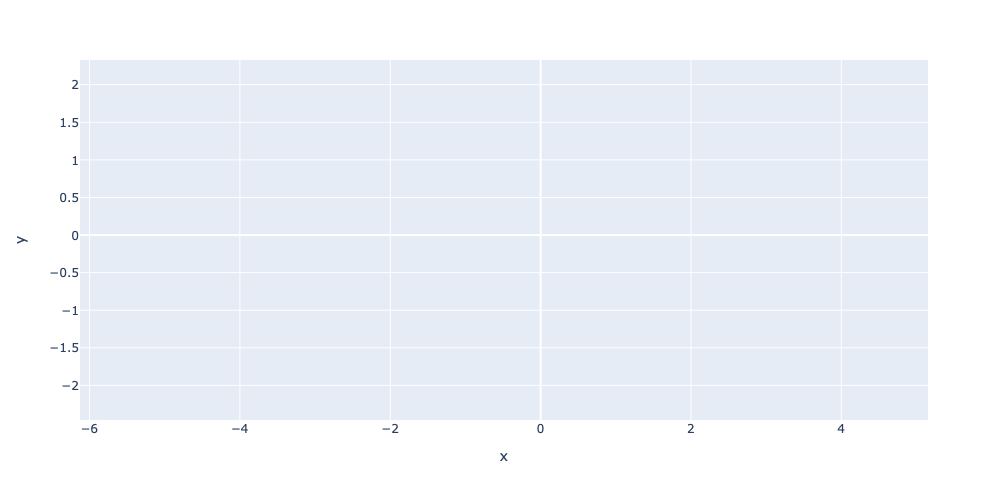

In [21]:
fig = px.scatter(x=data[:, 0], y=data[:, 1], width=700, height=500)
fig.update_traces(marker=dict(size=2))
fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()

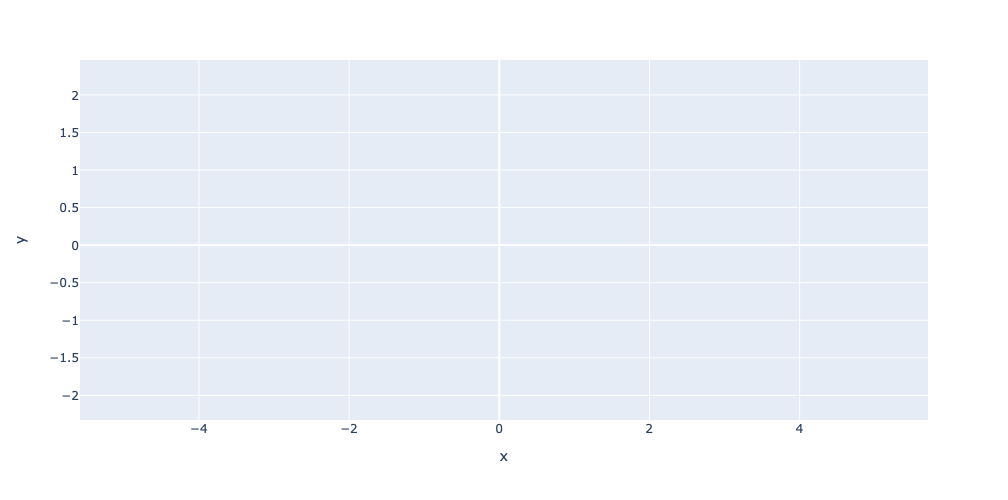

In [149]:
fig = px.scatter(x=data[:, 0], y=data[:, 1], width=700, height=500)
fig.update_traces(marker=dict(size=2))
fig.update_layout(yaxis=dict(scaleanchor="x", scaleratio=1))
fig.show()

In [103]:
data.shape

(1001, 3)

In [12]:
dataset.items

,title,genres,year
movieId,,,
1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
5,Father of the Bride Part II (1995),[Comedy],1995
...,...,...,...
193579,Jon Stewart Has Left the Building (2015),[Documentary],2015
193581,Black Butler: Book of the Atlantic (2017),"[Action, Animation, Comedy, Fantasy]",2017
193583,No Game No Life: Zero (2017),"[Animation, Comedy, Fantasy]",2017


In [13]:
dataset.histograms.get('year')

(array([  11,    1,    0,    0, 8059]),
 array([   0. ,  403.6,  807.2, 1210.8, 1614.4, 2018. ]))

In [67]:
np.histogram(dataset.items['year'], range=(1900, 2020))

(array([   2,   10,   82,  208,  284,  416,  652, 1642, 2920, 1843]),
 array([1900., 1912., 1924., 1936., 1948., 1960., 1972., 1984., 1996.,
        2008., 2020.]))

In [88]:
dataset.items['year'].quantile(.1)

1966.0

In [89]:
dataset.items['year'].quantile(.9)

2013.0

<AxesSubplot:>

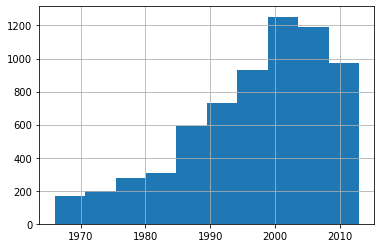

In [92]:
dataset.items['year'].hist(bins=10, range=(1966, 2013.0))

In [87]:
dataset.items['year'].median()

1999.0

In [37]:
class KNN(Model):
  def __init__(self, k=5):
    self.model = NearestNeighbors(n_neighbors=k, metric="cosine")

  def name(self):
    return "knn"

  def fit(self):
    self.model.fit(self.dataset.train_data)

  def predict(self, X, **kwargs):
    # the slowest phase of the prediction
    distances, indexes = self.model.kneighbors(X)

    n_distances = distances[:, 1:]
    n_indexes = indexes[:, 1:]

    n_distances = 1 - n_distances

    sums = n_distances.sum(axis=1)
    n_distances = n_distances / sums[:, np.newaxis]
        
    def f(dist, idx):
        A = self.dataset.train_data[idx]
        D = sp.diags(dist)
        return D.dot(A).sum(axis=0)
    
    vf = np.vectorize(f, signature='(n),(n)->(m)')

    pred = vf(n_distances, n_indexes)
        
    pred[(X > 0).toarray()] = 0

    return pred

In [38]:
model = KNN(k=20)
model.update_dataset(dataset)
model.fit()

In [39]:
X_pred = model.predict(dataset.vad_data_tr)

phase 1 done
phase 2 done


In [97]:
X_pred

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.103728  , 0.21258559, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.10169589, 0.2073023 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.05775506, 0.48042479, 0.0515738 , ..., 0.        , 0.        ,
        0.        ]])